In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

In [121]:
model = mlps.MLP(input_dimension=36, n_hidden_layers=0, hidden_dimension=20, n_actions=3)
# model = rnns.AttentiveRNN(input_dimension=128, hidden_dimension=50, truncate=10)  #, key_dimension=15)

In [122]:
optimiser = torch.optim.Adam(model.parameters(), lr=.1)

In [123]:
agent = agents.DQNAgent(model, optimiser, gamma=.9999, temperature=10, algorithm='expsarsa', n_actions=3)

In [124]:
environment = env.OverSimplifiedEnvironment(
    environment=gym.make('Breakout-ram-v0'), 
    agent=agent,
    verbose=True,
    max_steps=200,
    # slack=Slack(),
    capacity=5000,
    representation_method='observation'
)

# Experiment

In [125]:
agent.commit()

In [126]:
environment.exploration_episode()

(0.9971040563483742, 71)

100%|###############################################################| 10/10 [04:53<00:00, 28.73s/it]


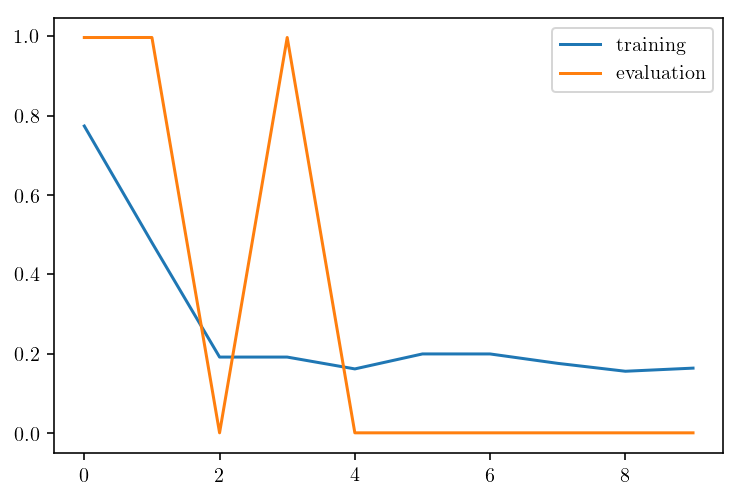

100%|###############################################################| 10/10 [04:03<00:00, 24.55s/it]


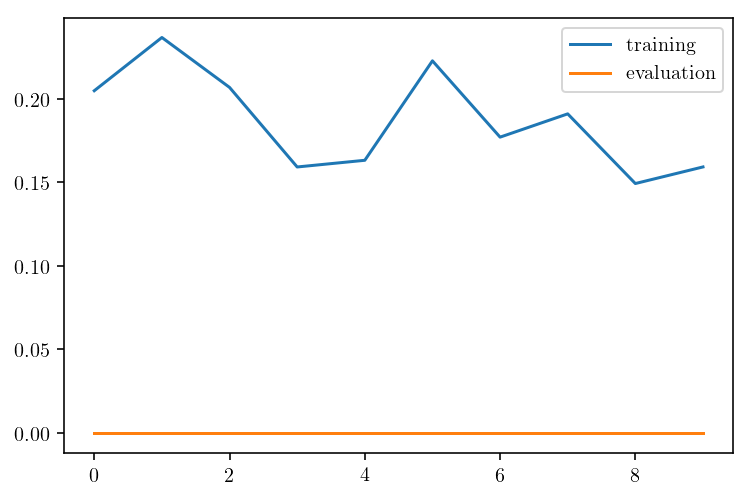

100%|###############################################################| 10/10 [04:33<00:00, 28.32s/it]


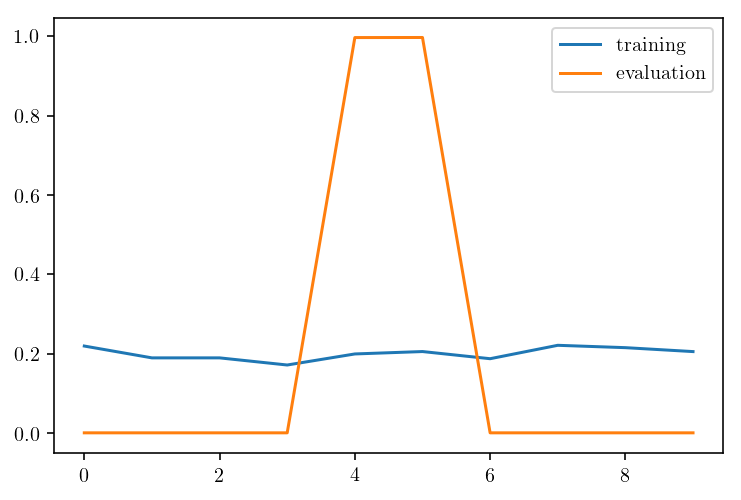

100%|###############################################################| 10/10 [04:01<00:00, 24.56s/it]


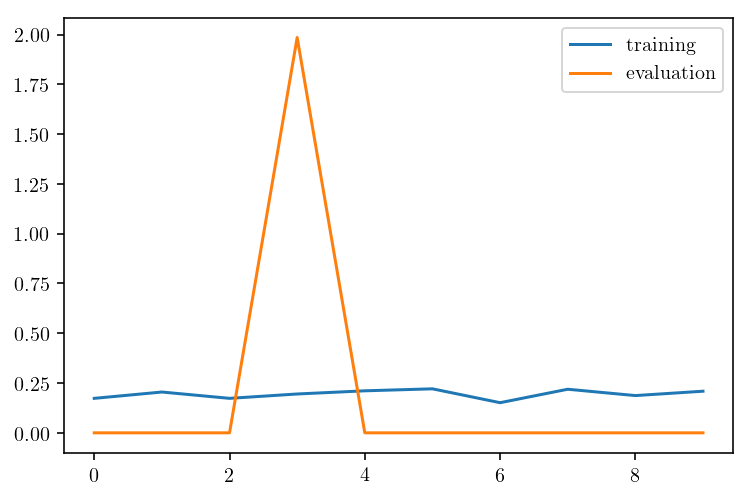

100%|###############################################################| 10/10 [04:15<00:00, 25.61s/it]


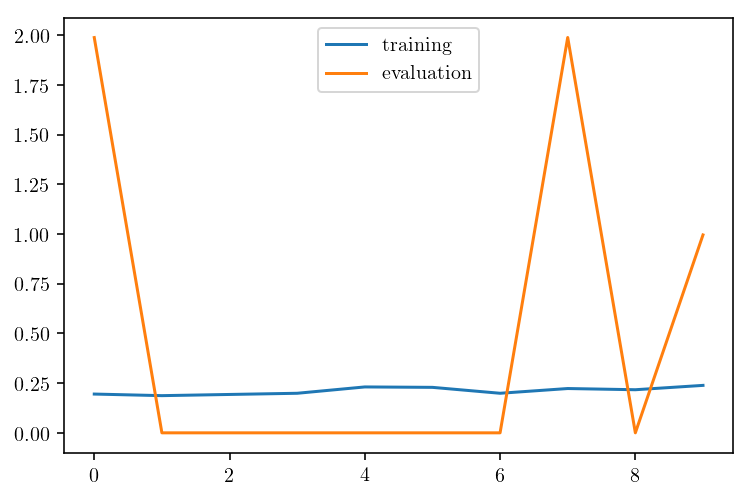

In [127]:
for _ in range(5):
    
    returns = environment.train(segments=10, episodes=500)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .8

In [ ]:
for _ in range(5):
    
    returns = environment.train(segments=10, episodes=500)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .8

In [ ]:
for _ in range(5):
    
    returns = environment.train(segments=10, episodes=500)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .9

In [ ]:
environment.environment.render()
environment.reset()

In [ ]:
environment.environment.render()
environment.environment.step(2)

In [ ]:
environment.environment.render()
environment.evaluation_episode()

In [ ]:
environment.evaluation_episode(render=True)

In [ ]:
agent.temperature

In [ ]:
environment.exploration_segment(20)

In [ ]:
environment.batch(100)

In [ ]:
environment.reset()
s = environment.state

In [ ]:
agent.q(s)

In [ ]:
agent.commit()

In [ ]:
agent.q(x)

In [ ]:
environment.evaluation_episode()

In [ ]:
state = environment.environment.reset()

agent.eval()

done = False
full_return = 0.

action = np.random.choice(environment.greedy(state))

counter = 0
while not done and counter < 10000:
    
    s, reward, done, i = environment.environment.step(action)

    # If there are ties, we might want to choose between actions at random
    a = np.random.choice(environment.greedy(s))

    # We store the new state and action
    state, action = s, a
    
    full_return = agent.gamma * full_return + reward
    counter += 1

full_return, counter

In [ ]:
state = environment.environment.reset()
action = np.random.choice(environment.greedy(state))

In [ ]:
s, reward, done, i = environment.environment.step(action)

# If there are ties, we might want to choose between actions at random
# a = np.random.choice(4, p=environment.epsilon_greedy(s, .1))
a = environment.environment.action_space.sample()

# We store the new state and action
state, action = s, a

done = done or i['ale.lives'] < 5

done, i, a

# Training

In [ ]:
environment.run(epochs=2, segments=5, episodes=50)

In [ ]:
environment.save('../saved/')